# 『ガウス過程と機械学習』3章

# 一般的な回帰

## 図3.1の実装
基底関数を動径基底関数
$$
\phi_h (x) = \exp{\{-\frac{(x-\mu_h)^2}{\sigma^2}\}}\ , \ (h = -H , \frac{1}{H} - H , ... , - \frac{1}{H}+H , H)
$$

としたときの回帰問題をサンプルとして提示します．

動径基底関数を用いた場合に柔軟に複雑な関数が作り出せることがわかるでしょう．

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
plt.style.available # スタイル確認

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
x = np.arange(-4 , 5 , 0.1 )

In [4]:
mu = np.arange(-3 , 5 , 1 )

In [10]:
sigma = 1

In [11]:
omega = np.array([-0.48 , -0.64 , 0.41 , 0.28 , 0.57 , 0.50 , -0.26 , 0.60])

In [12]:
def radial_basis_function(x , mu_h , sigma):
    phi = np.exp(- (x - mu_h / sigma)**2)
    return phi

In [13]:
def radial_basis_function_vecteor(x , mu , sigma):# xとmuは同じ次元のベクトル
    phi_vector = []
    length = len(mu)
    # ベクトルの各要素に対して基底関数を計算
    for i in range(length) :
        phi_vector.append(radial_basis_function(x , mu[i] , sigma))
    return phi_vector

In [14]:
def regression_function(x , omega , mu , sigma):
    phi_vector = radial_basis_function_vecteor(x , mu , sigma)
    y = np.dot(omega , phi_vector)
    return y
x1 = np.arange(-2, 2, 0.05) # x1点として[-2, 2]まで0.05刻みでサンプル
x2 = np.arange(-2, 2, 0.05)  # x2点として[-2, 2]まで0.05刻みでサンプル
x1, x2 = np.meshgrid(x1, x2)  # 上述のサンプリング点(x1,x2)を使ったメッシュ生成

In [15]:
phi_vector = radial_basis_function_vecteor(x , mu , sigma)

In [16]:
y = regression_function(x , omega , mu , sigma)

Text(0.5, 1.0, 'fig3.1')

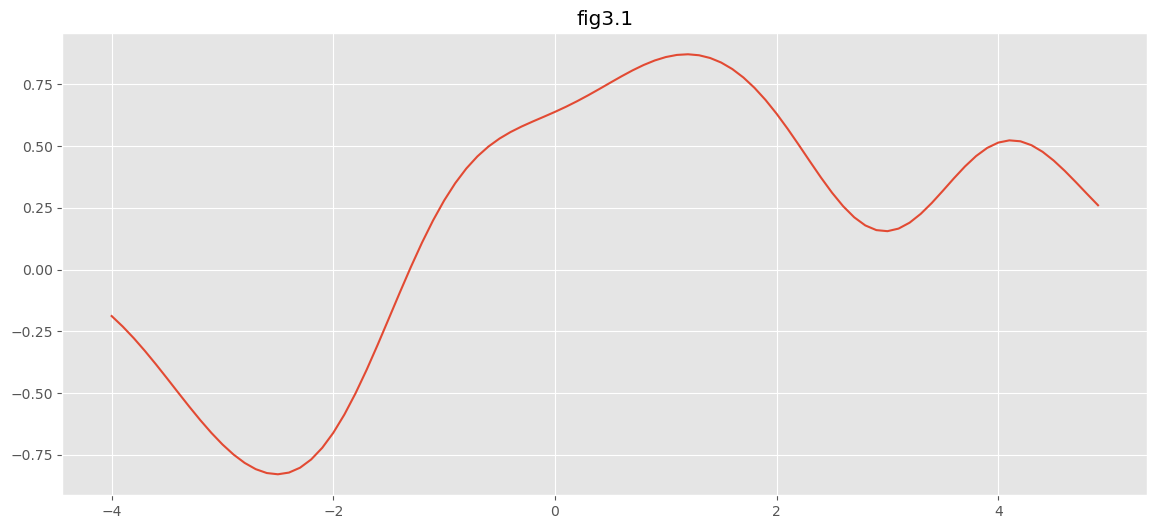

In [17]:
fig , ax = plt.subplots(figsize=(14, 6))

ax.plot(x , y , label = "regression_function")
ax.set_title("fig3.1")

柔軟に複雑な関数が扱える一方，$\omega$の次元が大きくすぎると過学習を起こすことはもちろん，計算量も大きくなります．(次元の呪い)

そこで，カーネル法を採用することで，基底関数$\phi$や$\omega$を明示的に表現せずに，カーネル関数$k(x,x')$を用いることで，カーネルトリックにより計算を行うことができます．

# カーネルリッジ回帰

教科書では，すぐにガウス過程回帰に入りますが，ここで足を止めビショップに習いカーネルリッジ回帰を実装してみます．

カーネルリッジ回帰の最適化アルゴリズムは，以下のようになります．

まず，カーネル$k(x,x')$を定義します．そのカーネル行列を用いて以下のように推定値を算出します．
$$
\hat{y}^*(x^* , D) = \vec{k}_*(K+\lambda I)^{-1}\vec{y}
$$

以下では，ガウシアンカーネルを用いた実装を具体的に示します．

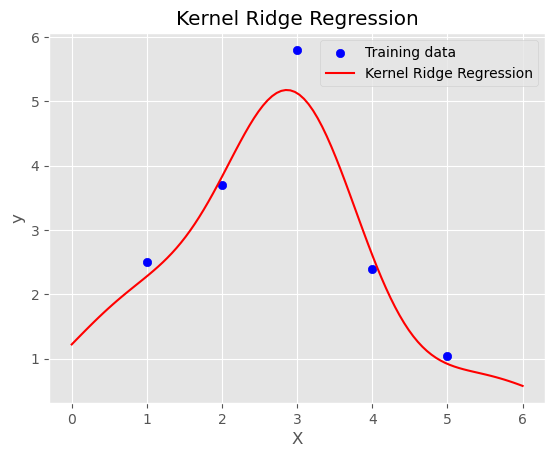

In [18]:
import numpy as np

class KernelRidgeRegression:
    def __init__(self, kernel='gaussian', bandwidth=1.0, regularization=0.1):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.regularization = regularization
        self.X = None
        self.y = None
        self.alpha = None

    # カーネル関数の計算
    def _calculate_similarity(self, x1, x2):
        if self.kernel == 'gaussian':
            distance = np.linalg.norm(x1 - x2)
            return np.exp(-0.5 * (distance / self.bandwidth) ** 2)
        elif self.kernel == 'linear':
            return np.dot(x1, x2)
        else:
            raise ValueError('Invalid kernel specified.')

    # グラム行列の計算
    def _calculate_kernel_matrix(self, X1, X2):
        n_samples1 = X1.shape[0]
        n_samples2 = X2.shape[0]
        K = np.zeros((n_samples1, n_samples2))
        for i in range(n_samples1):
            for j in range(n_samples2):
                K[i, j] = self._calculate_similarity(X1[i], X2[j])
        return K

    # 学習データから得られる式の係数を計算
    def fit(self, X, y):
        self.X = X
        self.y = y
        n_samples = X.shape[0]
        K = self._calculate_kernel_matrix(X, X)
        self.alpha = np.linalg.inv(K + self.regularization * np.eye(n_samples)).dot(y)
    
    # 予測
    def predict(self, X_test):
        y_pred = []
        K_test = self._calculate_kernel_matrix(X_test, self.X)
        for k_test in K_test:
            y_pred.append(np.dot(k_test, self.alpha))
        return np.array(y_pred)
    

# データセットの準備
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([2.5, 3.7, 5.8, 2.4, 1.05])

# カーネルリッジ回帰モデルの作成と学習
model = KernelRidgeRegression(kernel='gaussian', bandwidth=1.0, regularization=0.1)
model.fit(X, y)

# 新しい入力データに対する予測
X_test = np.linspace(0, 6, 100).reshape(-1, 1)
y_pred = model.predict(X_test)

# プロット
plt.scatter(X, y, color='b', label='Training data')
plt.plot(X_test, y_pred, color='r', label='Kernel Ridge Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Kernel Ridge Regression')
plt.legend()
plt.show()

# ガウス過程回帰
教科書に戻ります．

ガウス過程回帰は，カーネル回帰を確率的なモデリングの枠組みで捉えた手法です．

>教科書の引用
>>実際に，後に説明する式(3.79)のガウス過程に基づく予測分布は，期待値がカーネルリッジ回帰の結果と一致し，これにさらに分散を加えてガウス分布としたものになっています．
>>>式(3.79) : $p(y^{*} | \vec{x}^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)$

## 定義（確率過程)
:関数$f(x)$を確率的に生成する生成器

任意のN個の入力$\vec{x_1},...,\vec{x_N}$に対して，

N個の出力値$\vec{f_N} = (f(\vec{x_1}) ,..., f(\vec{x_N}))$の同時確率$p(\vec{f_N}) = p(f(\vec{x_1}) ,..., f(\vec{x_N}))$を与えることができるとき，この関係$f(・)$を確率過程と呼ぶ．


## 定義（ガウス過程）
確率過程$f(・)$が任意のN個の入力$\vec{x_1},...,\vec{x_N}$に対して，

N個の出力値$\vec{f_N} = (f(\vec{x_1}) ,..., f(\vec{x_N}))$の同時確率$p(\vec{f_N}) = p(f(\vec{x_1}) ,..., f(\vec{x_N}))$がガウス分布に従うとき，この関係$f(・)$をガウス過程と呼ぶ．これを

$$
f 〜 \textbf{GP}(\mu(\vec{x}), k(\vec{x}, \vec{x}'))
$$
とかく．

$\textbf{注意}$:
本来この分布は無限次元のガウス分布ですが，観測された有限個のデータに対する$(f(\vec{x_1}) ,..., f(\vec{x_N}))$に限って残りを周辺化したものを扱います．

## 図3.4の実装
ガウス過程の概念図を実装します．

ただし，今回カーネルは以下のように定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [19]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [20]:
Theta_1 , Theta_2 , Theta_3 = 10 , 1 , 0.1

In [21]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [22]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [23]:
kai = np.arange(-4 , 5 , 0.1 )

データ点からグラム行列を学習

In [24]:
K = compute_kernel(kai , Theta_1 , Theta_2 , Theta_3)

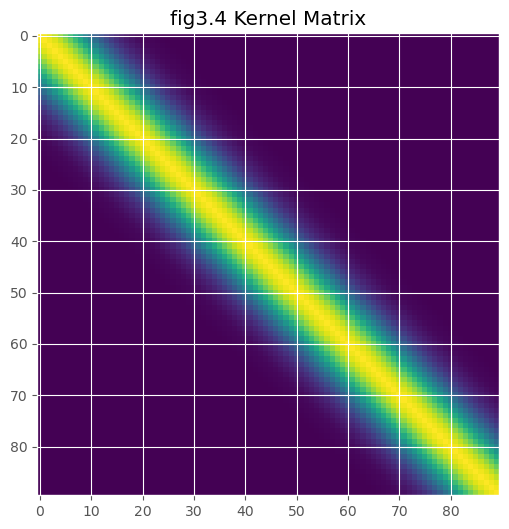

In [25]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
ax.set_title("fig3.4 Kernel Matrix")
plt.show()

学習したグラム行列から，ガウス過程の分散を算出しサンプルを描写．

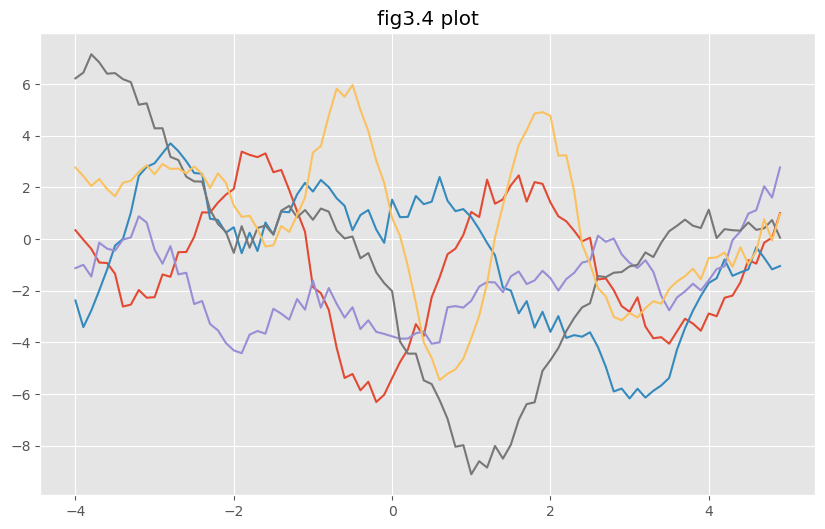

In [26]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(10, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.4 plot")
plt.show()

# 図3.11の実装

### 線形カーネル
$$
k(x , x^{'}) = \theta_1 x x^{'}
$$

In [27]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return p * np.dot(x, x_prime)

In [28]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [29]:
kai = np.arange(-4 , 5 , 0.1 )

In [30]:
K = compute_kernel(kai , Theta_1)

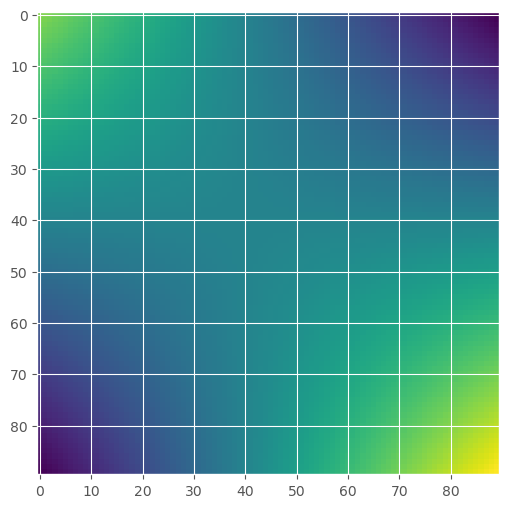

In [31]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

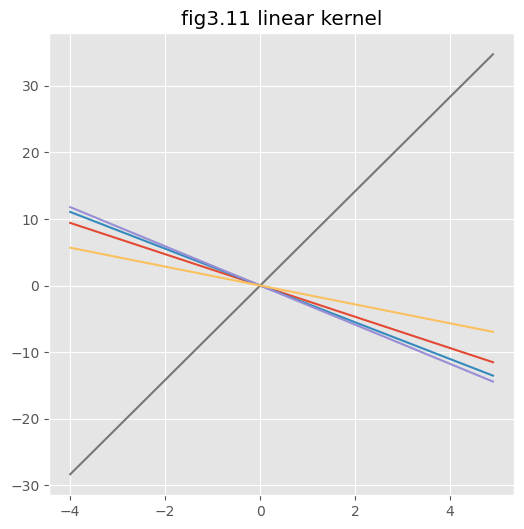

In [32]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.11 linear kernel")
plt.show()

### ガウスカーネル
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)}
$$

In [33]:
# カーネル関数を定義
def kernel(x, x_prime, p , q):
    return p * np.exp(-1 * (x - x_prime)**2 / q)

In [34]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1 , Theta_2)
    return K

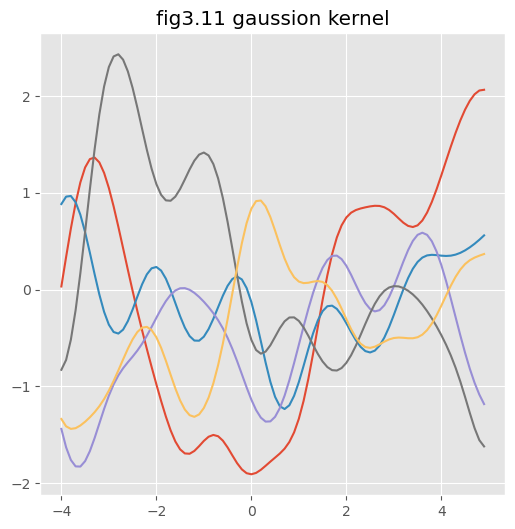

In [35]:
mu = 0 * kai
K = compute_kernel(kai , 1 , 1)
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.11 gaussion kernel")
plt.show()

### ビショップ(6.63)
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{2 \theta_2} \right)} + \theta_3 + \theta_4 x x^{'}
$$

In [36]:
# カーネル関数を定義
def kernel(x, x_prime, p , q , r , s):
    return p * np.exp(-1 * (x - x_prime)**2 / q) + r + s * x * x_prime

In [37]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3 , Theta_4):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1 , Theta_2 , Theta_3 , Theta_4)
    return K

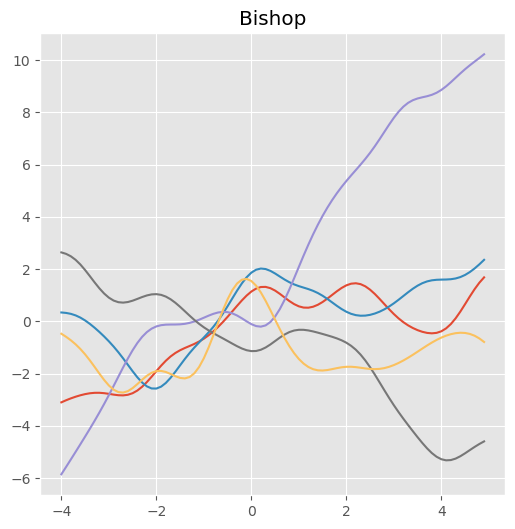

In [38]:
mu = 0 * kai
K = compute_kernel(kai , 1 , 1 , 1 , 1)
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("Bishop")
plt.show()

### 指数カーネル
$$
k(x , x^{'}) = \exp{\left( - \frac{|x - x^{'}|}{\theta} \right)}
$$

これはOUノイズに対応するもの．

#### ReMark:OUノイズ
OUノイズは，調和振動子ポテンシャルに従うブラウン運動である．

チャップマン・コロモゴロフ方程式(ガーディナー3.8.4節)
$$
\frac{\partial p(x , t)}{\partial t} =  \frac{\partial (k x p(x , t))}{\partial x} +\frac{D}{2} \frac{\partial^2 p(x , t)}{\partial x^2}
$$

確率微分方程式(ガーディナー4.5.4節)
$$
dx = -kx\ dt+ \sqrt{D}\ dW(t)
$$

積分方程式(ガーディナー4.5.4節)
$$
x(t) = x(0) \exp{\{-kt\}} + \sqrt{D} \int_0^t \exp{\{-k(t-s)\}} dW(s)
$$

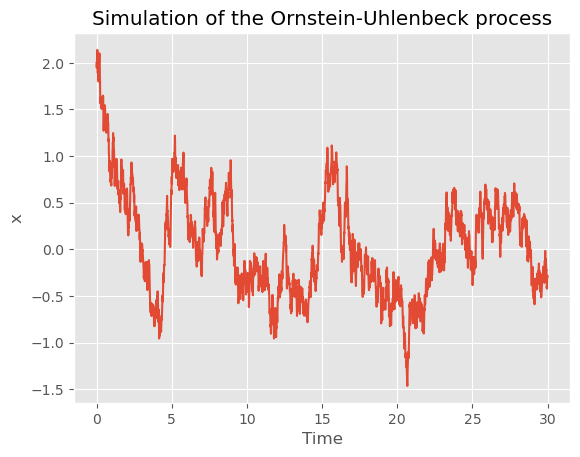

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 0.5  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 2.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列
x = np.zeros(N)  # xの値の配列
x[0] = x0

# シミュレーション
for i in range(N-1):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
    x[i+1] = x[i] - k * x[i] * dt + np.sqrt(D) * dW
    t[i+1] = t[i] + dt

# グラフのプロット
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulation of the Ornstein-Uhlenbeck process')
plt.grid(True)
plt.show()


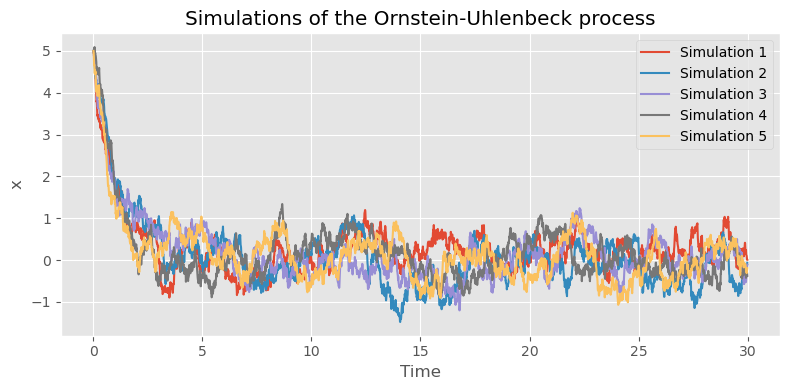

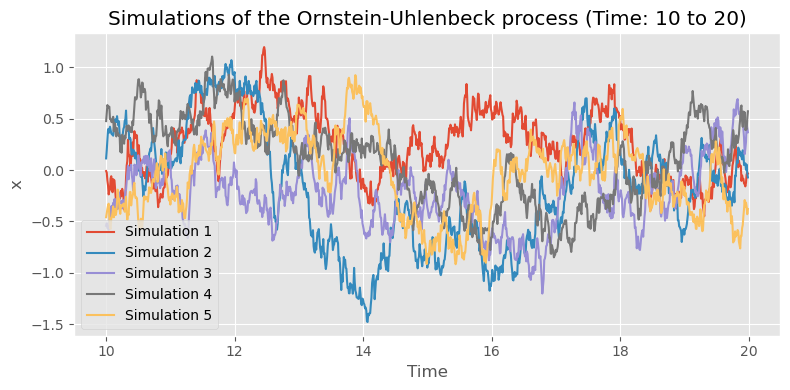

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # 定数 k
D = 0.5  # ノイズの強度 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 5.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 5  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 元の0から観測時間までのプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t, simulations[i], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 時間範囲の指定
t_start = 10.0
t_end = 20.0
start_index = int(t_start / dt)
end_index = int(t_end / dt)

# 時間指定したプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t[start_index:end_index], simulations[i, start_index:end_index], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process (Time: 10 to 20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


理論的な期待値
$$
E[x(t)] = x_0 \exp{\{-kt\}}
$$

理論的な分散
$$
Var[x(t)] = \frac{D}{2k} (1 - \exp{\{-2kt\}})
$$

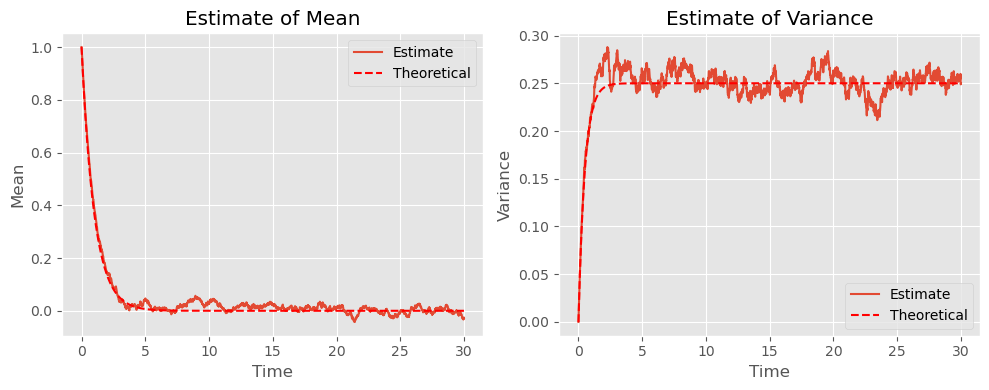

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 0.5  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 1.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 1000  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 期待値と分散の推定値の計算
mean_estimates = np.mean(simulations, axis=0)
variance_estimates = np.var(simulations, axis=0)

# 理論的な期待値と分散の計算
x_theoretical = x0 * np.exp(-k * t)
mean_theoretical = x0 * np.exp(-k * t)
variance_theoretical = (D / (2 * k)) * (1 - np.exp(-2 * k * t))

# グラフのプロット
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, mean_estimates, label='Estimate')
plt.plot(t, mean_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Estimate of Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, variance_estimates, label='Estimate')
plt.plot(t, variance_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Estimate of Variance')
plt.legend()

plt.tight_layout()
plt.show()

#### OUノイズの定常状態
OUノイズの定常分布は，以下のようになる．
$$
p_s(x) = \sqrt{ \frac{k}{\pi D} } \exp{\left( - \frac{ k x^2}{D} \right)}
$$

また，定常自己相関関数は以下のようになる．
$$
C(\tau) = \frac{D}{2k} \exp{\{-k|\tau|\}}
$$

この自己相関関数が，指数カーネルと一致します．

Remark:指数カーネル
$$
k(x , x^{'}) = \exp{\left( - \frac{|x - x^{'}|}{\theta} \right)}
$$

話は指数カーネルに戻ります．

In [42]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(-1 * np.abs(x - x_prime) / p)

In [43]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [44]:
kai = np.arange(0 , 10 , 0.01 )

In [45]:
K = compute_kernel(kai , 1)

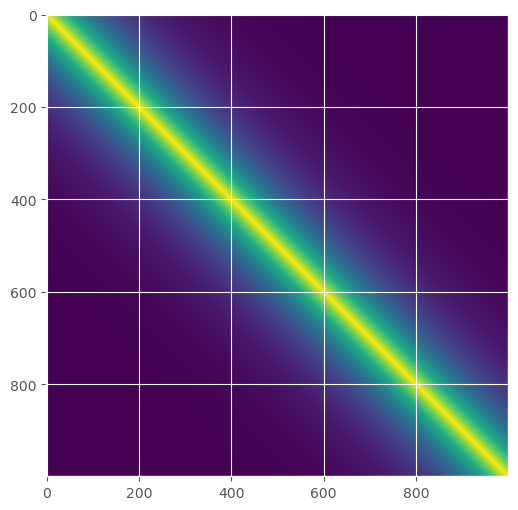

In [46]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

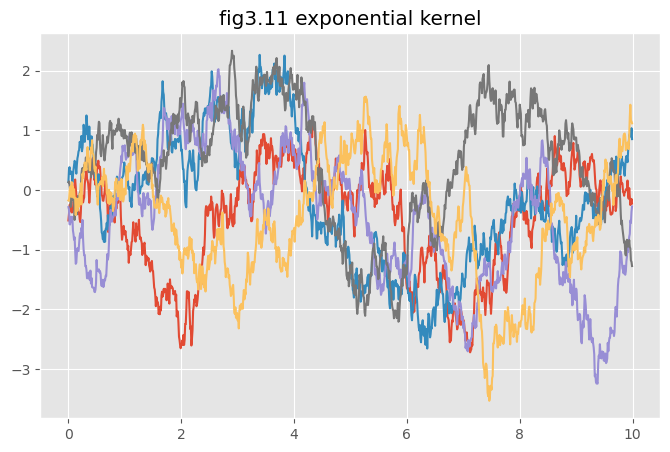

In [47]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(8, 5) )
ax.plot(kai, y.T)
ax.set_title("fig3.11 exponential kernel")
plt.show()

### 周期カーネル
$$
k(x , x^{'}) = \exp{\left( \theta_1 \cos(|x-x^{\prime}| / \theta_2)\right)}
$$

In [48]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(p * np.cos(x - x_prime) / p)

In [49]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [50]:
kai = np.arange(-20 , 20 , 0.1 )

In [51]:
K = compute_kernel(kai , Theta_1)

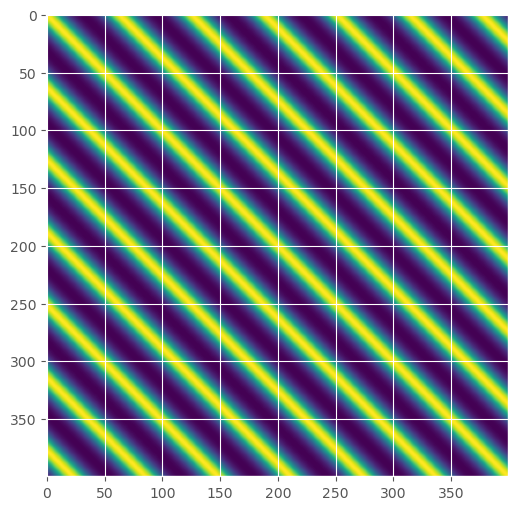

In [52]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

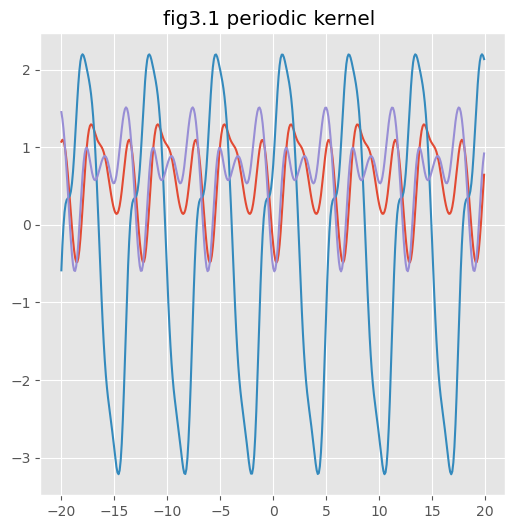

In [53]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 3)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.1 periodic kernel ")
plt.show()

## 図3.16の実装
ガウス過程回帰の予測結果に関する図の再現

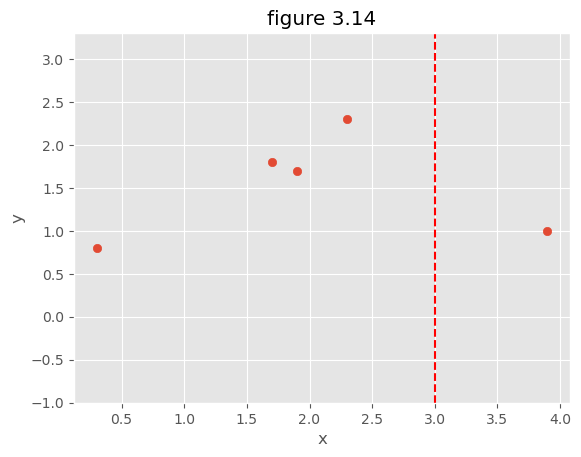

In [54]:
x = np.array([1.7 , 3.9, 1.9 , 0.3 , 2.3])
y = np.array([1.8 , 1.0 , 1.7 , 0.8 , 2.3])

plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1, max(max(y), abs(min(y))) + 1)
plt.axvline(x=3.0, linestyle='dashed', color='red')
plt.title('figure 3.14')
plt.show()

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | \vec{x}^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$
ただし，グラム行列$K$は
$$
K^{(train) } = 
\begin{pmatrix}
k(x_1 , x_1) & k(x_1,x_2) & k(x_1,x_3) & ・・・ & k(x_1,x_{N_{train}}) \\
k(x_2,x_1)  & k(x_2,x_2) & k(x_2,x_3) & ・・・ & k(x_2,x_{N_{train}})  \\
k(x_3,x_1)  & k(x_3,x_2) & k(x_3,x_3) & ・・・ & k(x_3,x_{N_{train}}) \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
k(x_{N_{train} }, x_1) & k(x_{N_{train}} , x_2) & k(x_{N_{train}} , x_3) & ・・・ & k(x_{N_{train}} , x_{N_{train}}) \\
\end{pmatrix}
$$

また，$\textbf{k}_*$は，以下のようなベクトルになります．
$$
\textbf{k}_* = (k(x^*,x_1) , k(x^*,x_2) , k(x^*,x_3) ,.... ,k(x^*,x_{N_{train}}))\top
$$

図3.16の予測では，以下のカーネルでやっています．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [55]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [56]:
# グラム行列の計算
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [57]:
# パラメータ値
Theta_1 = 1
Theta_2 = 5
Theta_3 = 0.01


# カーネル計算
K = compute_kernel(x , Theta_1 , Theta_2 , Theta_3)

In [58]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy

In [59]:
x_asterisk  = np.arange(0 , 5 , 0.2 ) 

In [60]:
# 予測分布の期待値，分散の計算
def predict(X_train , X_test , y , Theta_1 , Theta_2 , Theta_3) :
    # 平均
    mu = []
    # 分散
    var = []

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.69)式

    # K^{-1} * y を計算
        yy = Expected_train(K , y)

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

In [61]:
mu , var = predict(x , x_asterisk , y , Theta_1 , Theta_2 , Theta_3) 

In [62]:
# 予測分布の描画
import numpy as np
import matplotlib.pyplot as plt

# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train, y_train, X_test, mu, var):
    # 分散を標準偏差に変換
    std = np.sqrt(var)

    plt.figure(figsize=(10, 5))
    plt.title('fig 3.16', fontsize=20)
 
    # 元の信号
    plt.plot(X_train, y_train, 'x', color='green', label='Correct signal')
    
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='Mean by Gaussian process')

    plt.axvline(x=3.0, linestyle='dashed', color='red')

    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu - 2 * std, mu + 2 * std, alpha=0.2, color='blue', label='Standard deviation by Gaussian process')

    plt.legend(fontsize=12)
    plt.show()


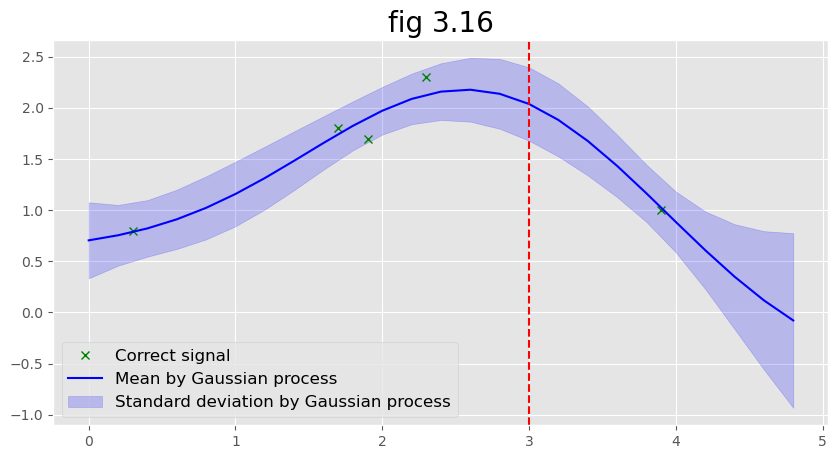

In [63]:
Gaussian_result(x , y , x_asterisk  , mu , var )